In [1]:
from utils import *
from text_preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
combined_df = preprocess_values(load_combined_df())
combined_df.head()


df shape:  (3000, 9)

rows with null values:  Int64Index([1551, 1552], dtype='int64')
rows that arent twitter:  1

dropped one row, fixed other null by dropping platform col, as unneeded

type of friends col:  int32

 country breakdown:  GB    2991
GG       5
JE       2
IM       1
Name: location.country, dtype: int64

df shape:  (2999, 8)


E:\Projects\bitbucket\fancy-a-challenge-william\utils.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_df = pd.concat([csv_df,txt_df])


,author.properties.friends,author.properties.status_count,author.properties.verified,content.body,location.country,location.latitude,location.longitude,properties.sentiment
0,1689,22566.0,False,Can't believe I'm missing Love Island 😩,GB,51.570448,0.457135,1.0
1,114,1377.0,False,Last tweet about future wedding..... if I actu...,GB,52.969744,-1.172266,1.0
2,568,8375.0,False,"How many times does he wonna say the phrase ""i...",GB,51.394369,0.026299,-1.0
3,1845,19394.0,False,...even better if time travel were invented an...,GB,51.648544,-3.804292,-1.0
4,1617,17922.0,False,@GreenAlty @ShakeyStephens My Mum in mid 80s p...,GB,53.543471,-2.653238,0.0


Given the skewed nature of the data set, I have over sampled the neutral and positive tweets, to balance it.

In [3]:
combined_df['sentiment'] = combined_df['properties.sentiment'].apply(lambda x: 'neg' if x ==-1 else 'neut' if x==0 else "pos")
combined_df['sentiment'].dtype
combined_df[['properties.sentiment','sentiment']].head()

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

combined_df.shape
ros = RandomOverSampler(random_state=777)

X_ROS, y_ROS = ros.fit_sample(combined_df, combined_df['sentiment'])
ros_df = pd.DataFrame(X_ROS,columns=combined_df.columns)
ros_df['sentiment'].value_counts()

data_train,data_test = train_test_split(ros_df,test_size=0.3,random_state=37)


In [4]:
import numpy as np
import pandas as pd
import re

from bs4 import BeautifulSoup

import sys
import os
import csv

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Masking
from keras.layers import Dense, Input, Flatten,GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional,SpatialDropout1D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping


MAX_SEQUENCE_LENGTH = 200
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.1

texts = data_train['content.body'].apply(lambda x: preprocess_no_variables(x))
#labels = data_train['sentiment']
labels = data_train['properties.sentiment']


Using TensorFlow backend.


To run this model it is necessary to have a glove embedding file in the root file.  If it is not there already,
this script will download it.  Beware this will add a one gigabyte file to your computer.

In [5]:
EMBEDDING_FILE = 'glove.6B.300d.txt'

if not os.path.exists(EMBEDDING_FILE):
    if not os.path.exists('glove.6B.zip'):
        ! wget http://nlp.stanford.edu/data/glove.6B.zip
    if not os.path.exists(EMBEDDING_FILE):
        ! unzip glove.6B.zip
        !rm glove.6B.100d.txt
        !rm glove.6B.50d.txt
        !rm glove.6B.200d.txt
    
import codecs

EMBEDDING_DIM = int(EMBEDDING_FILE.split('.')[-2][:-1])
EMBEDDING_DIM

300

In [6]:
embeddings_index = {}
f = open(os.path.abspath(EMBEDDING_FILE),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


I have found it more effective to split the sentiment label into three binary columns using one hot encoding.

In [7]:
data_train['sent'] = data_train['properties.sentiment'].apply(lambda x: x + 1).astype('str')

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
labels = onehotencoder.fit_transform(np.array(data_train['sent']).reshape(-1, 1)).toarray()


#just to check
sent_columns=['neg','neut','pos']
y_train = pd.DataFrame(x,columns=sent_columns)
assert(y_train[y_train.isnull().any(axis=1)].empty)
y_train.head()

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,neg,neut,pos
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


Here I have used preprocessing with removes completely uservariables and urls.  In another exercise, more could be
done to evaluate these, possibly look at domain names for example, but in the short run it is easier to ignore.

In [8]:
print('Shape of data tensor:', len(texts))
print('Shape of label tensor:', len(labels))

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(data_test.shape)

test_texts= data_test['content.body'].apply(lambda x: preprocess_no_variables(x)).values

Shape of data tensor: 2946
Shape of label tensor: 2946


c:\users\wburke\projects\venv36\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(1263, 9)


In [9]:
test_tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(test_texts)
test_sequences = test_tokenizer.texts_to_sequences(test_texts)
test_word_index = test_tokenizer.word_index
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(test_data.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

(1263, 200)


In [10]:
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print ('Length of embedding_matrix:', embedding_matrix.shape[0])
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            mask_zero=False,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


print('Traing and validation set number of positive and negative reviews')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Length of embedding_matrix: 4947
Traing and validation set number of positive and negative reviews
[874. 895. 883.]
[103.  90. 101.]


In [11]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [17]:
import keras_metrics


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
sentLayer = SpatialDropout1D(0.1)(embedded_sequences)
l_lstm = Bidirectional(LSTM(64, return_sequences=True))(sentLayer)
x = Bidirectional(GRU(64, return_sequences=True))(l_lstm)

x1 = Attention(MAX_SEQUENCE_LENGTH)(x)
x2 = GlobalAveragePooling1D()(x)
x3 = GlobalMaxPooling1D()(x)
x = Concatenate()([x1, x2, x3])

dense_1 = Dense(256,activation='relu')(x)
dropout_2=Dropout(0.15)(dense_1)
dense_2 = Dense(3, activation='softmax')(dropout_2)

model = Model(sequence_input, dense_2)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc',keras_metrics.precision(), keras_metrics.recall()])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     1484100     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 200, 300)     0           embedding_1[1][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200, 128)     186880      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [18]:

filepath="data/predict-goal-weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
callbacks_list = [checkpoint,early_stop]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=32,shuffle=True,
                    callbacks=callbacks_list)

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2652 samples, validate on 294 samples
Epoch 1/10
2652/2652 [==============================] - 68s 26ms/step - loss: 0.9014 - acc: 0.5701 - precision: 0.6393 - recall: 0.3913 - val_loss: 0.7052 - val_acc: 0.6837 - val_precision: 0.6900 - val_recall: 0.6699

Epoch 00001: val_acc improved from -inf to 0.68367, saving model to data/predict-goal-weights.best.hdf5
Epoch 2/10
2652/2652 [==============================] - 76s 29ms/step - loss: 0.5023 - acc: 0.8118 - precision: 0.8164 - recall: 0.7632 - val_loss: 0.7023 - val_acc: 0.7381 - val_precision: 0.6364 - val_recall: 0.8155

Epoch 00002: val_acc improved from 0.68367 to 0.73810, saving model to data/predict-goal-weights.best.hdf5
Epoch 3/10
2652/2652 [==============================] - 79s 30ms/step - loss: 0.3486 - acc: 0.8756 - precision: 0.8662 - recall: 0.8593 - val_loss: 0.6870 - val_acc: 0.7653 - val_precision: 0.6585 - val_recall: 0.7864

Epoch 00003: val_acc improved from 0.73810 to 0.76531, saving model to data/predict-g

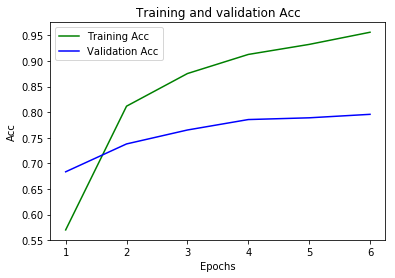

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [20]:
csvfile = open('output.csv', 'w') 
writer = csv.writer(csvfile)
writer.writerow(['statement','label'])

a=np.array(model.predict(test_data, batch_size=32, verbose=1))

label_names = ['negative','neutral','positive']

output=[]
for i in range(len(test_texts)):
    text = test_texts[i]
    label_col = label_names[np.argmax(a,axis=1)[i]]
    output_a=[text,label_col]
    output.append(output_a)
    print(label_col,':',text)
print(output)
model.save('data/sentiment-LSTM-Model.h5')
 
writer.writerows(output)
csvfile.close()

1263/1263 [==============================] - 10s 8ms/step
negative :   woof exclamation
neutral : video will be in the morning now
negative : if you ever gonna sleep at mine just know we are gonna watch joan rivers do not start with me so sexy is not it
positive : feel like this was created just for you  
positive : imagine been able to tweet about something fun nope not me have no idea exclamation i am so boring face with tears of joy face with tears of joy
positive :  i am on page # this month exclamation
positive : gee's little laugh is adorable sparkles smiling face see no evil monkey
positive : my mood is pile of poo
positive : when  makes the whole house watch the drivel that is skull skull
negative :  yes then jack congrats on #zerozerok well done
positive :   it does not matter how they became that way telling them oh its okay is only going to make it worse
positive :  ha ha blush
positive : there are places i will not work because of this important that we acknowledge the past

neutral : living with freshers for fourth year was such a mistake
neutral : your grandchildren will be mick hucknall fans
neutral :  i am ok thanks have you had a good day xx
neutral :   what some journalists mistake for news these days 
negative :  haha you were obsessed with him xx
positive :   could have ironed his shirt or used some of his onezerozero zerozero a week to hire someone to iron it new moon face
negative : i think they are gonna reveal the woodpecker the dog and then the bug tomorrow
negative :  brb crying
negative :  hugs
negative : ok it is done now to bed 
positive : kevin hart is just casually walking in london what why am i not there
negative :  is my life omg
negative : i am sorry i missed this great storify exclamation 
negative : slightly smiling face
neutral :   lemme read this now loudly crying face
neutral :  blimey you still have not served enough time here
neutral : if my neighbours could stop shouting that would be great
negative :  thankyou for rt xx
posi

negative : loves george
positive :  yey thankyou again xx
positive : second chorus of badlands  at hampden park glasgow tonight great show 
positive :   sadly not lemon drizzle cake type of drizzle happy
negative :  that was a really good watch great team great players and as you say great manager sheringham looks like he hasnt aged exclamation
positive : i always saw you for what you could have been
positive :   fantastic skills exclamation
neutral : day one birthday theme for kelley  blonde hair lipgloss killer eyeliner kiss mark kiss mark lipstick kiss mark kiss mark lipstick 
negative :    i saw him with my own two eyes at the previous show he attacked her exclamation
positive : imagine being able to get a decent night sleep smiling face with smiling eyes
positive : check out what i found  via 
negative : i disliked a  video from   why i should join vale exclamation   
negative :    hmm the lexus have gone either same us team that ran the very poor jaguar team about # years ago
neu

negative : jo mcgonigal spatialised painting #zeroone# detail blanket white neon artist palette 
negative : first you delete the data and then you replace the data with data that attempts to describe the meaning of the original data to a machine
neutral :  you are too fucked bmt
neutral :   listen here buddy 
neutral :  many established onest generation immigrants want to restrict immigration many #nd generation eg irish more welcoming
negative : lol lol lol lol too much lol too much laughter lol lol too much
negative : it honestly grosses me out at how many underage girls you lure in and try your luck with disgusting dirty little boy
negative :  you are such a lovely person i am sorry we did not get more time to natter hope you had a great time exclamation
negative :  i am beggin you folded hands folded hands folded hands folded hands soccer ball red heart person raising hand soccer ball red heart person raising hand
neutral : thank you to everyone it means a lot  
positive : tweeps e

positive :  perrfect exclamation enjoy it for me exclamation happy
positive :     very well said exclamation exclamation
neutral : 
neutral : it is still wednesday exclamation my first non courtier crypt ghast 
neutral :  
positive :  hi sorry i hope you do not mind me following you on here at all i am hayley and i also love as well happy
negative : love my bro 
negative : a long time by mayer hawthorne is in harrods london
negative : in  on ##p t bar beer mug 
positive : gee's little laugh is adorable sparkles smiling face see no evil monkey
negative : tier is relevant
negative : oi oi 
negative :  lol very very sugary drinks and fizzy shit pensive face pensive face
negative : najwiksi ktrych zabraknie na euro we francji 
negative : a saudi wealth fund just invested # #bn in uber  via 
negative : so she had just self expressed herself to death now nothing's left dove cherry blossom sun behind large cloud sparkles
negative :  i only have pizzas at #am if i have been drinking unfortunat